In [10]:
%load_ext jupyter_black

In [2]:
import json
from glob import glob
from pathlib import Path
from typing import NewType, Iterable, Callable

import numpy as np
import pandas as pd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

idx: slice = pd.IndexSlice

In [12]:
MIN_PROBSEVERE = 20


def load_parquet(path: str) -> pd.DataFrame:
    """function to load a data frame and convert the data type to 32 bit float"""
    df = pd.read_parquet(path)
    mask = df.columns[~df.columns.isin(("MAXRC_EMISS", "MAXRC_ICECF", "geometry"))]
    df[mask] = df[mask].astype(np.float32)
    return df


df = load_parquet("/workspaces/sppp/data/2022-07.parquet")
# bool values of where the max PS for a storm was less that 20
mask = df["PS"].groupby("ID").max() > MIN_PROBSEVERE
# index the dataframe with the storm id's where ps > 20
df = df.loc[idx[:, mask[mask].index], :]

In [22]:
df = df.copy()
# convert each geomtery array into a Polygon, and unpack x,y
x1, y1 = np.array(
    tuple((Polygon(list(arr)).centroid.xy for arr in df["geometry"])),
    dtype=np.float32,
).T[0]
# create 2 arrays to represent our grid space
x2 = np.linspace(
    -129.995,  # west lon
    -60.005002000040975,  # east lon
    7000,  # points in between
    dtype=np.float32,
)
y2 = np.linspace(
    20.005000000002696,  # south lat
    54.995,  # north lat
    2500,  # points in between
    dtype=np.float32,
)
# create a common axis with [:,np.newaxis] subtract the arrays, index the gridspace with the index position
df["x"] = x2[np.argmin(abs(x1 - x2[:, np.newaxis]), axis=0)]
df["y"] = y2[np.argmin(abs(y1 - y2[:, np.newaxis]), axis=0)]

<GeoAxesSubplot:xlabel='x', ylabel='y'>

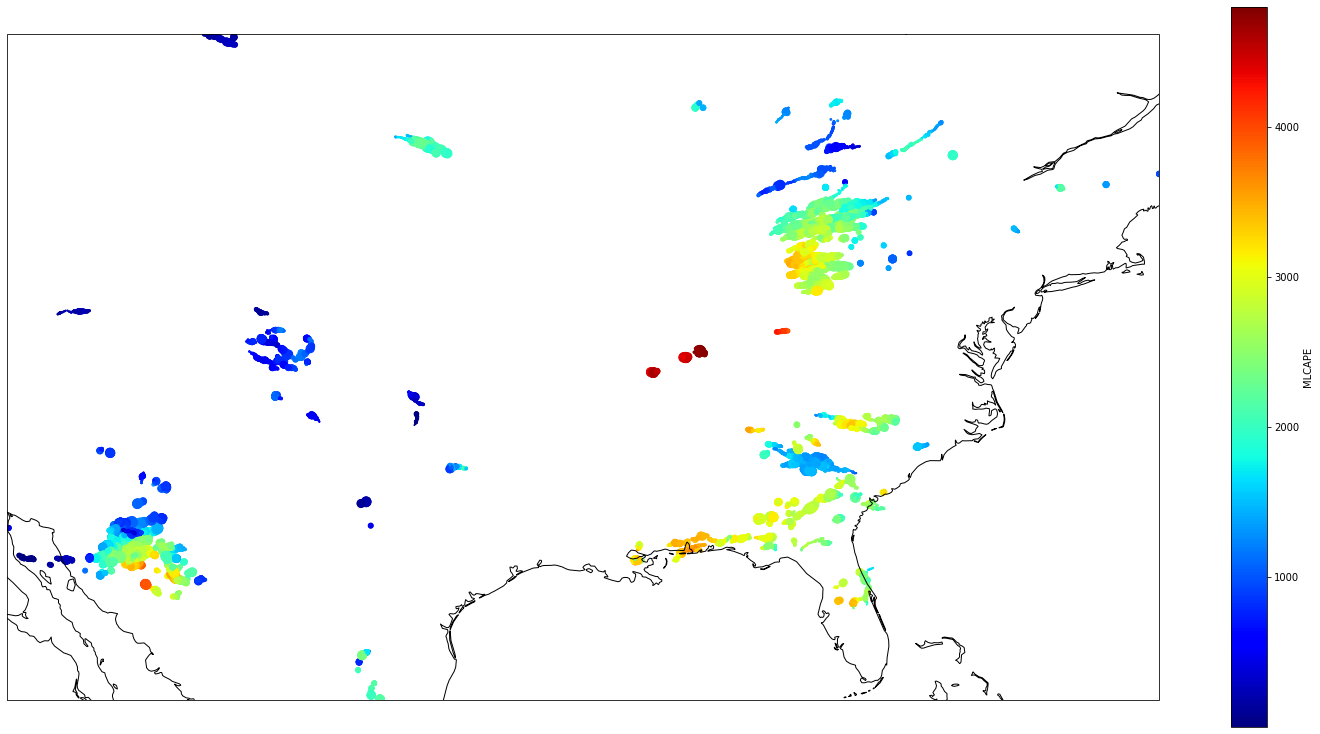

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111, aspect="equal", projection=ccrs.PlateCarree())
ax.set_extent(
    [
        *df["x"].agg(["min", "max"]),
        *df["y"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)
ax.coastlines("50m")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

df.plot.scatter(
    x="x",
    y="y",
    c="MLCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax,
)

In [8]:
df.drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],
).loc[df.index.unique("validTime"), :]

MUCAPE  MLCAPE  MLCIN    EBSHEAR  SRH01KM  \
validTime           ID                                                  
2022-07-20 01:04:40 355308  1818.0  1438.0  -12.0  16.900000     73.0   
                    356333  1691.0  1389.0   -5.0  33.099998     39.0   
                    357275  2794.0   932.0  -27.0  20.600000      0.0   
                    357278  3396.0  1892.0  -25.0  33.799999     20.0   
                    357362  2153.0  1831.0  -20.0  32.299999     36.0   
...                            ...     ...    ...        ...      ...   
2022-07-20 23:58:43 370044  2776.0  2459.0   -7.0  39.599998    165.0   
                    370051  3139.0  2938.0  -11.0  38.599998    180.0   
                    370052  2898.0   846.0  -20.0  42.200001     10.0   
                    370082  4968.0  4538.0   -8.0  32.700001     46.0   
                    370127  3785.0  2151.0  -48.0  40.500000    138.0   

                            MEANWIND_1-3kmAGL  MESH  VIL_DENSITY  FLASH_RATE  \
validTime           ID                                                         
2022-07-20 01:04:40 355308          17.900000  0.77         2.34        40.0   
                    356333          17.000000  0.18         1.72         1.0   
                    357275           7.600000  0.49         1.70         5.0   
                    357278           3.300000  1.15         1.91        23.0   
                    357362           7.700000  0.00         0.86         0.0   
...                                       ...   ...          ...         ...   
2022-07-20 23:58:43 370044          36.000000  0.42         1.61        38.0   
                    370051          33.900002  0.49         2.15        47.0   
                    370052           5.900000  0.59         2.07        23.0   
                    370082          17.900000  0.41         1.90        12.0   
                    370127          15.600000  0.62         1.03         1.0   

                            FLASH_DENSITY  ...  WETBULB_0C_HGT  PWAT  \
validTime           ID                     ...                         
2022-07-20 01:04:40 355308           1.17  ...            13.1   2.1   
                    356333           0.06  ...            11.6   1.6   
                    357275           0.34  ...            11.3   1.3   
                    357278           0.49  ...            12.2   1.4   
                    357362           0.10  ...            12.4   2.0   
...                                   ...  ...             ...   ...   
2022-07-20 23:58:43 370044           0.86  ...            11.3   1.8   
                    370051           0.40  ...            12.1   1.9   
                    370052           0.36  ...            11.5   1.3   
                    370082           0.29  ...            13.7   2.3   
                    370127           0.04  ...             8.5   1.1   

                            CAPE_M10M30  LJA   SIZE  MOTION_EAST  \
validTime           ID                                             
2022-07-20 01:04:40 355308        430.0  0.0  434.0        5.333   
                    356333        487.0  0.0   77.0        5.449   
                    357275        462.0  0.0  273.0        0.912   
                    357278        728.0  0.0  234.0       -2.726   
                    357362        473.0  0.0  315.0        2.139   
...                                 ...  ...    ...          ...   
2022-07-20 23:58:43 370044        800.0  0.0  207.0        6.186   
                    370051        871.0  0.0  379.0        8.153   
                    370052        482.0  0.6  204.0        4.220   
                    370082       1278.0  0.0   73.0        3.611   
                    370127        912.0  0.0   42.0        4.220   

                            MOTION_SOUTH    PS           x          y  
validTime           ID                                                 
2022-07-20 01:04:40 355308        -0.627  19.0  -81.825005  33.530548  

In [11]:
def prepare_data(df:pd.DataFrame,min_probsevere:int=20)->pd.DataFrame:
    mask = df["PS"].groupby("ID").max() > min_probsevere
    # index the dataframe with the storm id's where ps > 20
    df = df.loc[idx[:,mask[mask].index],:].copy()
    x1, y1 = np.array(
        tuple((Polygon(list(arr)).centroid.xy for arr in df["geometry"])),
        dtype=np.float32,
    ).T[0]
    # create 2 arrays to represent our grid space
    x2 = np.linspace(
        -129.995,
        -60.005002000040975,
        7000,
        dtype=np.float32,
    )
    y2 = np.linspace(
        54.995,
        20.005000000002696,
        2500,
        dtype=np.float32,
    )
    # # create a common axis with [:,np.newaxis] subtract the arrays, index the gridspace with the index position
    df.loc[:,"x"] = x2[np.argmin(abs(x1 - x2[:, np.newaxis]), axis=0)]
    df.loc[:,"y"] = y2[np.argmin(abs(y1 - y2[:, np.newaxis]), axis=0)]
    return df.drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],
).loc[df.index.unique("validTime"), :]

df = load_parquet("/workspaces/sppp/data/2022-07.parquet").pipe(prepare_data)
# bool values of where the max PS for a storm was less that 20
df


MUCAPE  MLCAPE  MLCIN    EBSHEAR  SRH01KM  \
validTime           ID                                                  
2022-07-20 01:04:40 355308  1818.0  1438.0  -12.0  16.900000     73.0   
                    356333  1691.0  1389.0   -5.0  33.099998     39.0   
                    357275  2794.0   932.0  -27.0  20.600000      0.0   
                    357278  3396.0  1892.0  -25.0  33.799999     20.0   
                    357362  2153.0  1831.0  -20.0  32.299999     36.0   
...                            ...     ...    ...        ...      ...   
2022-07-20 23:58:43 370044  2776.0  2459.0   -7.0  39.599998    165.0   
                    370051  3139.0  2938.0  -11.0  38.599998    180.0   
                    370052  2898.0   846.0  -20.0  42.200001     10.0   
                    370082  4968.0  4538.0   -8.0  32.700001     46.0   
                    370127  3785.0  2151.0  -48.0  40.500000    138.0   

                            MEANWIND_1-3kmAGL  MESH  VIL_DENSITY  FLASH_RATE  \
validTime           ID                                                         
2022-07-20 01:04:40 355308          17.900000  0.77         2.34        40.0   
                    356333          17.000000  0.18         1.72         1.0   
                    357275           7.600000  0.49         1.70         5.0   
                    357278           3.300000  1.15         1.91        23.0   
                    357362           7.700000  0.00         0.86         0.0   
...                                       ...   ...          ...         ...   
2022-07-20 23:58:43 370044          36.000000  0.42         1.61        38.0   
                    370051          33.900002  0.49         2.15        47.0   
                    370052           5.900000  0.59         2.07        23.0   
                    370082          17.900000  0.41         1.90        12.0   
                    370127          15.600000  0.62         1.03         1.0   

                            FLASH_DENSITY  ...  WETBULB_0C_HGT  PWAT  \
validTime           ID                     ...                         
2022-07-20 01:04:40 355308           1.17  ...            13.1   2.1   
                    356333           0.06  ...            11.6   1.6   
                    357275           0.34  ...            11.3   1.3   
                    357278           0.49  ...            12.2   1.4   
                    357362           0.10  ...            12.4   2.0   
...                                   ...  ...             ...   ...   
2022-07-20 23:58:43 370044           0.86  ...            11.3   1.8   
                    370051           0.40  ...            12.1   1.9   
                    370052           0.36  ...            11.5   1.3   
                    370082           0.29  ...            13.7   2.3   
                    370127           0.04  ...             8.5   1.1   

                            CAPE_M10M30  LJA   SIZE  MOTION_EAST  \
validTime           ID                                             
2022-07-20 01:04:40 355308        430.0  0.0  434.0        5.333   
                    356333        487.0  0.0   77.0        5.449   
                    357275        462.0  0.0  273.0        0.912   
                    357278        728.0  0.0  234.0       -2.726   
                    357362        473.0  0.0  315.0        2.139   
...                                 ...  ...    ...          ...   
2022-07-20 23:58:43 370044        800.0  0.0  207.0        6.186   
                    370051        871.0  0.0  379.0        8.153   
                    370052        482.0  0.6  204.0        4.220   
                    370082       1278.0  0.0   73.0        3.611   
                    370127        912.0  0.0   42.0        4.220   

                            MOTION_SOUTH    PS           x          y  
validTime           ID                                                 
2022-07-20 01:04:40 355308        -0.627  19.0  -81.825005  33.530548  

In [5]:
ps_100_2022 = df_2022.loc[df_2022["PS"] == PROB_SEVERE].index.unique("ID")
ps_100_2022

Index(['357877', '358776', '358782', '358768', '365855', '364627', '357279',
       '366243', '366548', '368355', '367657', '368722', '367316', '369187',
       '359420', '359169', '358192'],
      dtype='object', name='ID')

In [6]:
def x_and_y(df: pd.DataFrame, grid: GridSpace) -> pd.DataFrame:
    """calculate geometric center of storm and fit the stom to the gridspace"""

    def generate():
        for arr in df["geometry"]:
            point = Polygon(arr.tolist()).centroid
            yield point.x, point.y

    x, y = np.array(tuple(generate()), dtype=np.float32).T
    # index position of nearest grid
    df["X"] = np.argmin(abs(x[:, np.newaxis] - grid.x), axis=1)
    df["Y"] = np.argmin(abs(y[:, np.newaxis] - grid.y), axis=1)
    # TODO: compute the aprox grid step based on ME and MS

    return df


gdf_2021 = df_2021.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)
gdf_2022 = df_2022.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)

In [7]:
gdf_2022.shape, gdf_2021.shape
assert (gdf_2021.dtypes == gdf_2022.dtypes).all()

In [8]:
# unique storms with a 100% ProbSevere
_2021 = gdf_2021.loc[idx[:, ps_100_2021], :]
_2022 = gdf_2022.loc[idx[:, ps_100_2022], :]

In [9]:
columns = [
    "PS",
    "X",
    "Y",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MLCIN",
    "MUCAPE",
    "MLCAPE",
    "MESH",
    "VIL_DENSITY",
]


def embed(df: pd.DataFrame) -> pd.DataFrame:
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    # Principal component analysis (PCA).
    pca = PCA(n_components=1, svd_solver="arpack")
    df["CAPE"] = pca.fit_transform(
        df[
            [
                "MLCIN",
                "MUCAPE",
                "MLCAPE",
            ]
        ]
    )

    return df[
        ["PS", "X", "Y", "MOTION_EAST", "MOTION_SOUTH", "CAPE", "MUCAPE", "MLCAPE"]
    ]


def resize_ps(df: pd.DataFrame) -> pd.DataFrame:
    df["PS"] = df["PS"] * (df["PS"] * 0.010)
    return df

<AxesSubplot:xlabel='X', ylabel='Y'>

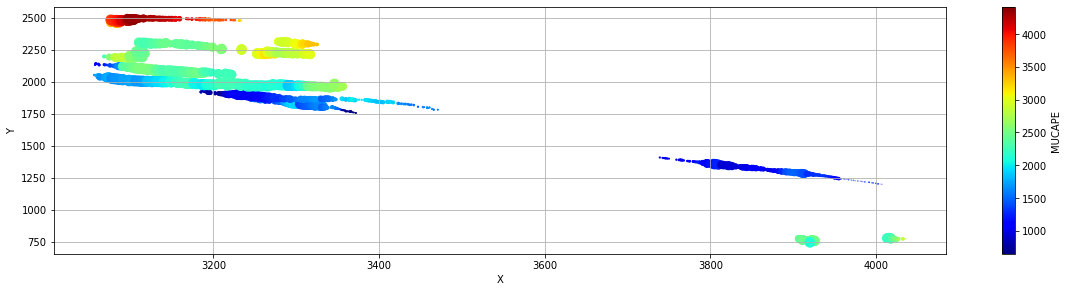

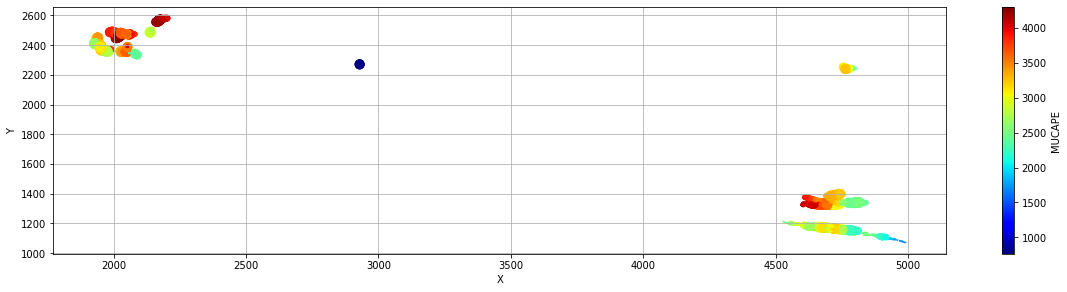

In [10]:
import cartopy.crs as ccrs

plt.rcParams["axes.grid"] = True
#
plt.figure(1)
ax1 = plt.subplot(211)
_2021.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax1,
    figsize=(20, 10),
)
plt.figure(2)
ax2 = plt.subplot(211)
_2022.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax2,
    # ax=axs[0, 1],
    figsize=(20, 10),
)

In [ ]:
import functools
from gym.spaces import Discrete
from pettingzoo import ParallelEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils import parallel_to_aec

#                 "MOTION_EAST": "1.233", "MOTION_SOUTH": "-0.212",
EAST = 1
SOUTH = 1
NORTH = -1
WEST = -1
# ROCK = 0
# PAPER = 1
# SCISSORS = 2
# NONE = 3
MOVES = ["ROCK", "PAPER", "SCISSORS", "None"]
NUM_ITERS = 100
REWARD_MAP = {
    # (ROCK, ROCK): (0, 0),
    # (ROCK, PAPER): (-1, 1),
    # (ROCK, SCISSORS): (1, -1),
    # (PAPER, ROCK): (1, -1),
    # (PAPER, PAPER): (0, 0),
    # (PAPER, SCISSORS): (-1, 1),
    # (SCISSORS, ROCK): (-1, 1),
    # (SCISSORS, PAPER): (1, -1),
    # (SCISSORS, SCISSORS): (0, 0),
}


def env():
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    env = raw_env()
    # This wrapper is only for environments which print results to the terminal
    env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


def raw_env():
    """
    To support the AEC API, the raw_env() function just uses the from_parallel
    function to convert from a ParallelEnv to an AEC env
    """
    env = parallel_env()
    env = parallel_to_aec(env)
    return env


class parallel_env(ParallelEnv):
    metadata = {"render_modes": ["human"], "name": "rps_v2"}

    def __init__(self):
        """
        The init method takes in environment arguments and should define the following attributes:
        - possible_agents
        - action_spaces
        - observation_spaces

        These attributes should not be changed after initialization.
        """
        self.possible_agents = ["player_" + str(r) for r in range(2)]
        self.agent_name_mapping = dict(
            zip(self.possible_agents, list(range(len(self.possible_agents))))
        )

    # this cache ensures that same space object is returned for the same agent
    # allows action space seeding to work as expected
    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
        return Discrete(4)

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return Discrete(3)

    def render(self, mode="human"):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        if len(self.agents) == 2:
            string = "Current state: Agent1: {} , Agent2: {}".format(
                MOVES[self.state[self.agents[0]]], MOVES[self.state[self.agents[1]]]
            )
        else:
            string = "Game over"
        print(string)

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None):
        """
        Reset needs to initialize the `agents` attribute and must set up the
        environment so that render(), and step() can be called without issues.

        Here it initializes the `num_moves` variable which counts the number of
        hands that are played.

        Returns the observations for each agent
        """
        self.agents = self.possible_agents[:]
        self.num_moves = 0
        observations = {agent: None for agent in self.agents}
        return observations

    def step(self, actions):
        """
        step(action) takes in an action for each agent and should return the
        - observations
        - rewards
        - dones
        - infos
        dicts where each dict looks like {agent_1: item_1, agent_2: item_2}
        """
        # If a user passes in actions with no agents, then just return empty observations, etc.
        if not actions:
            self.agents = []
            return {}, {}, {}, {}

        # rewards for all agents are placed in the rewards dictionary to be returned
        rewards = {}
        rewards[self.agents[0]], rewards[self.agents[1]] = REWARD_MAP[
            (actions[self.agents[0]], actions[self.agents[1]])
        ]

        self.num_moves += 1
        env_done = self.num_moves >= NUM_ITERS
        dones = {agent: env_done for agent in self.agents}

        # current observation is just the other player's most recent action
        observations = {
            self.agents[i]: int(actions[self.agents[1 - i]])
            for i in range(len(self.agents))
        }

        # typically there won't be any information in the infos, but there must
        # still be an entry for each agent
        infos = {agent: {} for agent in self.agents}

        if env_done:
            self.agents = []

        return observations, rewards, dones, infos


# grid.reward_matrix(-127, 50)
# len(grid.x)
grid.x, grid.y

In [ ]:
# https://www.pettingzoo.ml/sisl/pursuit

len(grid.x)

In [ ]:
# import gym
# import tensorflow as tf
from pettingzoo.sisl import pursuit_v4
from pettingzoo.butterfly import pistonball_v6

from sppp.transfer.funcs import mask_frames_by_id
from sppp.transfer.const import GridSpace

# env = pistonball_v6.env()
zeros = grid.zeros_grid()


class SPPPEnv(gym.Env):
    def __init__(self, state: "State") -> None:
        self.state = state

    def _compute_reward(self) -> int:
        return 1

    def step(self, action: np.ndarray):
        # action is produced by DQN, action is discrete
        # self.cache.move(action)
        # compute reward based on state(position) of the car
        # storm_state = self.car_agent.getCarState()
        # reward = self._compute_reward(storm_state)
        # # check if the episode is done
        # car_controls = self.car_agent.getCarControls()
        # done = self._isDone(storm_state, car_controls, reward)
        # # log info
        # info = {}
        # # observation is RGB image from car's camera
        # observation = self.car_agent.observe()
        observation = self.state.latests
        reward = self._compute_reward()
        done = False
        info = {}
        return observation, reward, done, info

    @property
    def observation_space(self) -> pd.DataFrame:
        return self.state.latests


def iterframe(df: pd.DataFrame) -> Iterable[tuple[pd.Timestamp, pd.DataFrame]]:
    yield from df.groupby("validTime")


n_inputs = 4
state = State()
env = SPPPEnv(state)
loss = keras.losses.binary_crossentropy
reward_map = make_reward_map()


n_outputs = 5
box_shape = 5


def reward_matrix(x: int, y: int, box_size: int = 5):
    gamefield = (
        zeros.loc[
            y - box_size : y + box_size,
            x - box_size : x + box_size,
        ].copy()
        + reward_map
    )
    return gamefield.values


transition_probs = [[0, 0, 1] * 20] * 101
possible_actions = [[0, 1, 2], [0, 2], [1]] * 101  # [list(range(-5, 5))] * 101


def swp_class_ploicy(
    state: int,  # probiblity of severe weather
    epsilon=0,
):
    if np.random.rand() < epsilon:
        return np.random.randint()
    # v = model.predict(state[np.newaxis])
    return np.random.choice(possible_actions[state])


class SevereWeatherClassifcation:
    def policy(self, series: pd.Series) -> np.ndarray:
        return 1


swc = SevereWeatherClassifcation()

if __name__ == "__main__":
    for vt, df in iterframe(midf.loc[idx[:, "89519"], :]):
        track_rewards = 0
        obs = env.reset()
        # evaluate prediction
        if state.has_hist():
            # there is existing storm information normalize frame_a and frame_b by the the in's in the index
            frame_a, frame_b = mask_frames_by_id(state.latests, df)
            # assert that the frames are of an equal shape
            assert frame_a.shape == frame_b.shape
            # bg = frame_b[["MOTION_EAST", "MOTION_SOUTH", "STAB"]].values
            # x = play_one_step(env, bg, model, loss)
            # obs, reward, done, info = env.step(frame_b[["MOTION_EAST", "MOTION_SOUTH"]])
            with tf.GradientTape() as tape:
                for x, s in frame_b.iterrows():
                    model = build_model(s)
                    reward = grid.reward_matrix(s.X, s.Y)
                    action = swc.policy(s)
        state.set_storm(df)

reward

In [ ]:
reward.stack().plot()